# Figures 3 - 6 in Stan and Mantripragada (2023)

In [1]:
import numpy as np
import xarray as xr
import proplot as pplt
import pandas as pd
from sklearn.metrics import mean_squared_error
import scipy.signal as sig
from sklearn.metrics import r2_score
import scipy.stats

In [2]:
pplt.rc.update({'meta.width':1,'ticklabelweight':'bold', 'axeslabelweight':'bold','titleweight':'bold','fontname':'Noto Sans','fontsize':32,'titlesize':34})

In [3]:
def filtwghts_lanczos(nwt, filt_type, fca, fcb):
	
    """
    Calculates the Lanczos filter weights.
    
    Parameters
    ----------
    nwt : int
        The number of weights.
    filt_type : str
        The type of filter. Must be one of 'low', 'high', or 'band'.
    fca : float
        The cutoff frequency for the low or band filter.
    fcb : float
        The cutoff frequency for the high or band filter.
    
    Returns
    -------
    w : ndarray
        The Lanczos filter weights.
    
    Notes
    -----
    The Lanczos filter is a type of sinc filter that is truncated at a specified frequency.
    This function implements a Lanczos filter in the time domain.
    """	
	
    pi = np.pi
    k = np.arange(-nwt, nwt+1)

    if filt_type == 'low':
        w = np.zeros(nwt*2+1)
        w[:nwt] = ((np.sin(2 * pi * fca * k[:nwt]) / (pi * k[:nwt])) * np.sin(pi * k[:nwt] / nwt) / (pi * k[:nwt] / nwt))
        w[nwt+1:] = ((np.sin(2 * pi * fca * k[nwt+1:]) / (pi * k[nwt+1:])) * np.sin(pi * k[nwt+1:] / nwt) / (pi * k[nwt+1:] / nwt))
        w[nwt] = 2 * fca
    elif filt_type == 'high':
        w = np.zeros(nwt*2+1)
        w[:nwt] = -1 * (np.sin(2 * pi * fcb * k[:nwt]) / (pi * k[:nwt])) * np.sin(pi * k[:nwt] / nwt) / (pi * k[:nwt] / nwt)
        w[nwt+1:] = -1 * (np.sin(2 * pi * fcb * k[nwt+1:]) / (pi * k[nwt+1:])) * np.sin(pi * k[nwt+1:] / nwt) / (pi * k[nwt+1:] / nwt)
        w[nwt] = 1 - 2 * fcb
    else:
        w1 = np.zeros(nwt*2+1)
        w1[:nwt] = (np.sin(2 * pi * fca * k[:nwt]) / (pi * k[:nwt])) * np.sin(pi * k[:nwt] / nwt) / (pi * k[:nwt] / nwt)
        w1[nwt+1:] = (np.sin(2 * pi * fca * k[nwt+1:]) / (pi * k[nwt+1:])) * np.sin(pi * k[nwt+1:] / nwt) / (pi * k[nwt+1:] / nwt)
        w1[nwt] = 2 * fca
        w2 = np.zeros(nwt*2+1)
        w2[:nwt] = (np.sin(2 * pi * fcb * k[:nwt]) / (pi * k[:nwt])) * np.sin(pi * k[:nwt] / nwt) / (pi * k[:nwt] / nwt)
        w2[nwt+1:] = (np.sin(2 * pi * fcb * k[nwt+1:]) / (pi * k[nwt+1:])) * np.sin(pi * k[nwt+1:] / nwt) / (pi * k[nwt+1:] / nwt)
        w2[nwt] = 2 * fcb
        w = w2 - w1
		
    return w

# Function for Index of Agreement (IOA)
def index_agreement(s, o):
    ia = 1 -(np.sum((o-s)**2))/(np.sum(
            (np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

### Enter latitude and longitude bounds of the domain

In [4]:
lat_north, lat_south, long_west, long_east = 7.5, -7.5, 125, 270

### Load the blended surface zonal wind stress data. 
The dataset is described here (Lybarger et al. 2020):
https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020JC016732

In [5]:
inDir = '/scratch/rmantrip/windstress/'
# Load precomputed blended daily mean zonal wind stress anomalies
tauxa = xr.open_dataset(inDir+'blended.taux.anom.nc').taux.sel(lat=slice(lat_south,lat_north),lon=slice(long_west,long_east)) 
# Load pre-computed 30-90-day Lanczos filtered anomalies
taux_bpf = xr.open_dataset(inDir+'blended.tauxi.nc').taux.sel(lat=slice(lat_south,lat_north),lon=slice(long_west,long_east)) 

# Fill the missing values with the values to the nearest longitude
# Raw scatterometer data has missing values at 180 longitude
tauxa[:,:,110] = tauxa[:,:,109]
tauxa[:,:,111] = tauxa[:,:,112]
taux_bpf[:,:,110] = taux_bpf[:,:,109] 
taux_bpf[:,:,111] = taux_bpf[:,:,112]

### Load the NOAA interpolated data. 
The NOAA interpolated data is downloaded from: https://downloads.psl.noaa.gov/Datasets/interp_OLR/olr.day.mean.nc 

In [6]:
# NOAA interpolated daily mean OLR
olriFile = '/homes/rmantrip/testPyISV/olr.day.i.mean.nc'
olri = xr.open_dataset(olriFile).sel(lat=slice(lat_north,lat_south),lon=slice(long_west,long_east),time=slice('1980',None)).olr

### Get the years to split the dataset into training, validation, and testing. 

In [7]:
startTrain, endTrain, startVal, endVal, startTest, endTest = '1988', '2012', '2013', '2014', '2015', '2016'

### Calculate climatology based only on the training period. This will avoid test data leakages or bias.
### Calculate unfiltered anomalies and band pass filtered anomalies 

In [8]:
########################## OLR ##########################
# Calculate the climatology

olri_clim = olri.sel(time=slice(startTrain, endTrain)).groupby("time.dayofyear").mean("time")

# Calculate the anomalies

olri_anom = olri.groupby("time.dayofyear") - olri_clim

# Calculate 30-90-day band pass Lanczos filterd olr anomalies 

nwgths = 90 # The filter uses 181 (nwgths*2+1) weights
tpa = 30 # Time period: 30-day
tpb = 90 # Time period: 90-day
wgths = filtwghts_lanczos(nwgths,'band',1/tpb,1/tpa)
wgths = xr.DataArray(wgths, dims=['window'])

olri_bpf = olri_anom.rolling(time=len(wgths), center=True).construct('window').dot(wgths)

### Regrid taux to match with the dimension of OLR. Load the CNN filtered OLR and taux

In [9]:
### Regridding the zonal wind stress to match with OLR spatial resolution
tauxa = tauxa.interp(lon=olri_anom.lon,lat=olri_anom.lat).sel(time=slice(startTest, endTest))
taux_bpf = taux_bpf.interp(lon=olri_anom.lon,lat=olri_anom.lat).sel(time=slice(startTest, endTest))

olri_anom = olri_anom.sel(time=slice(startTest, endTest))
olri_bpf = olri_bpf.sel(time=slice(startTest, endTest))

# Load CNN filtered OLR and zonal wind stress anomalies
inpath1 = '/homes/rmantrip/testPyISV/cnnweights/olr/'
inpath2 = '/homes/rmantrip/testPyISV/cnnweights/taux/'
olricnn = xr.open_dataset(inpath1+'olr.cnn.bpf.nc').olr
tauxicnn = xr.open_dataset(inpath2+'taux.cnn.bpf.nc').taux

tauxicnn = tauxicnn.interp(lon=olri_anom.lon,lat=olri_anom.lat)

In [10]:
### Latitudinal average and difference between 30-90-day anomalies filtered using Lanczos and CNN
## Zonal Wind Stress
tauxa_meanlat = tauxa.mean('lat')
tauxi_meanlat_lan = taux_bpf.mean('lat')
tauxi_meanlat_cnn = tauxicnn.mean('lat')
tauxi_diff = tauxi_meanlat_lan - tauxi_meanlat_cnn
## OLR
olra_meanlat = olri_anom.mean('lat')
olri_meanlat_lan = olri_bpf.mean('lat')
olri_meanlat_cnn = olricnn.mean('lat')
olri_diff = olri_meanlat_lan - olri_meanlat_cnn
### create dates to replace with noleap calendar dates in taux
dates = pd.date_range(start="2015-01-01",end="2016-12-31")
dates = dates[~((dates.month == 2) & (dates.day == 29))]
tauxa_meanlat['time'] = dates
tauxi_meanlat_lan['time'] = dates
tauxi_meanlat_cnn['time'] = dates
tauxi_diff['time'] = dates

### Figure 3

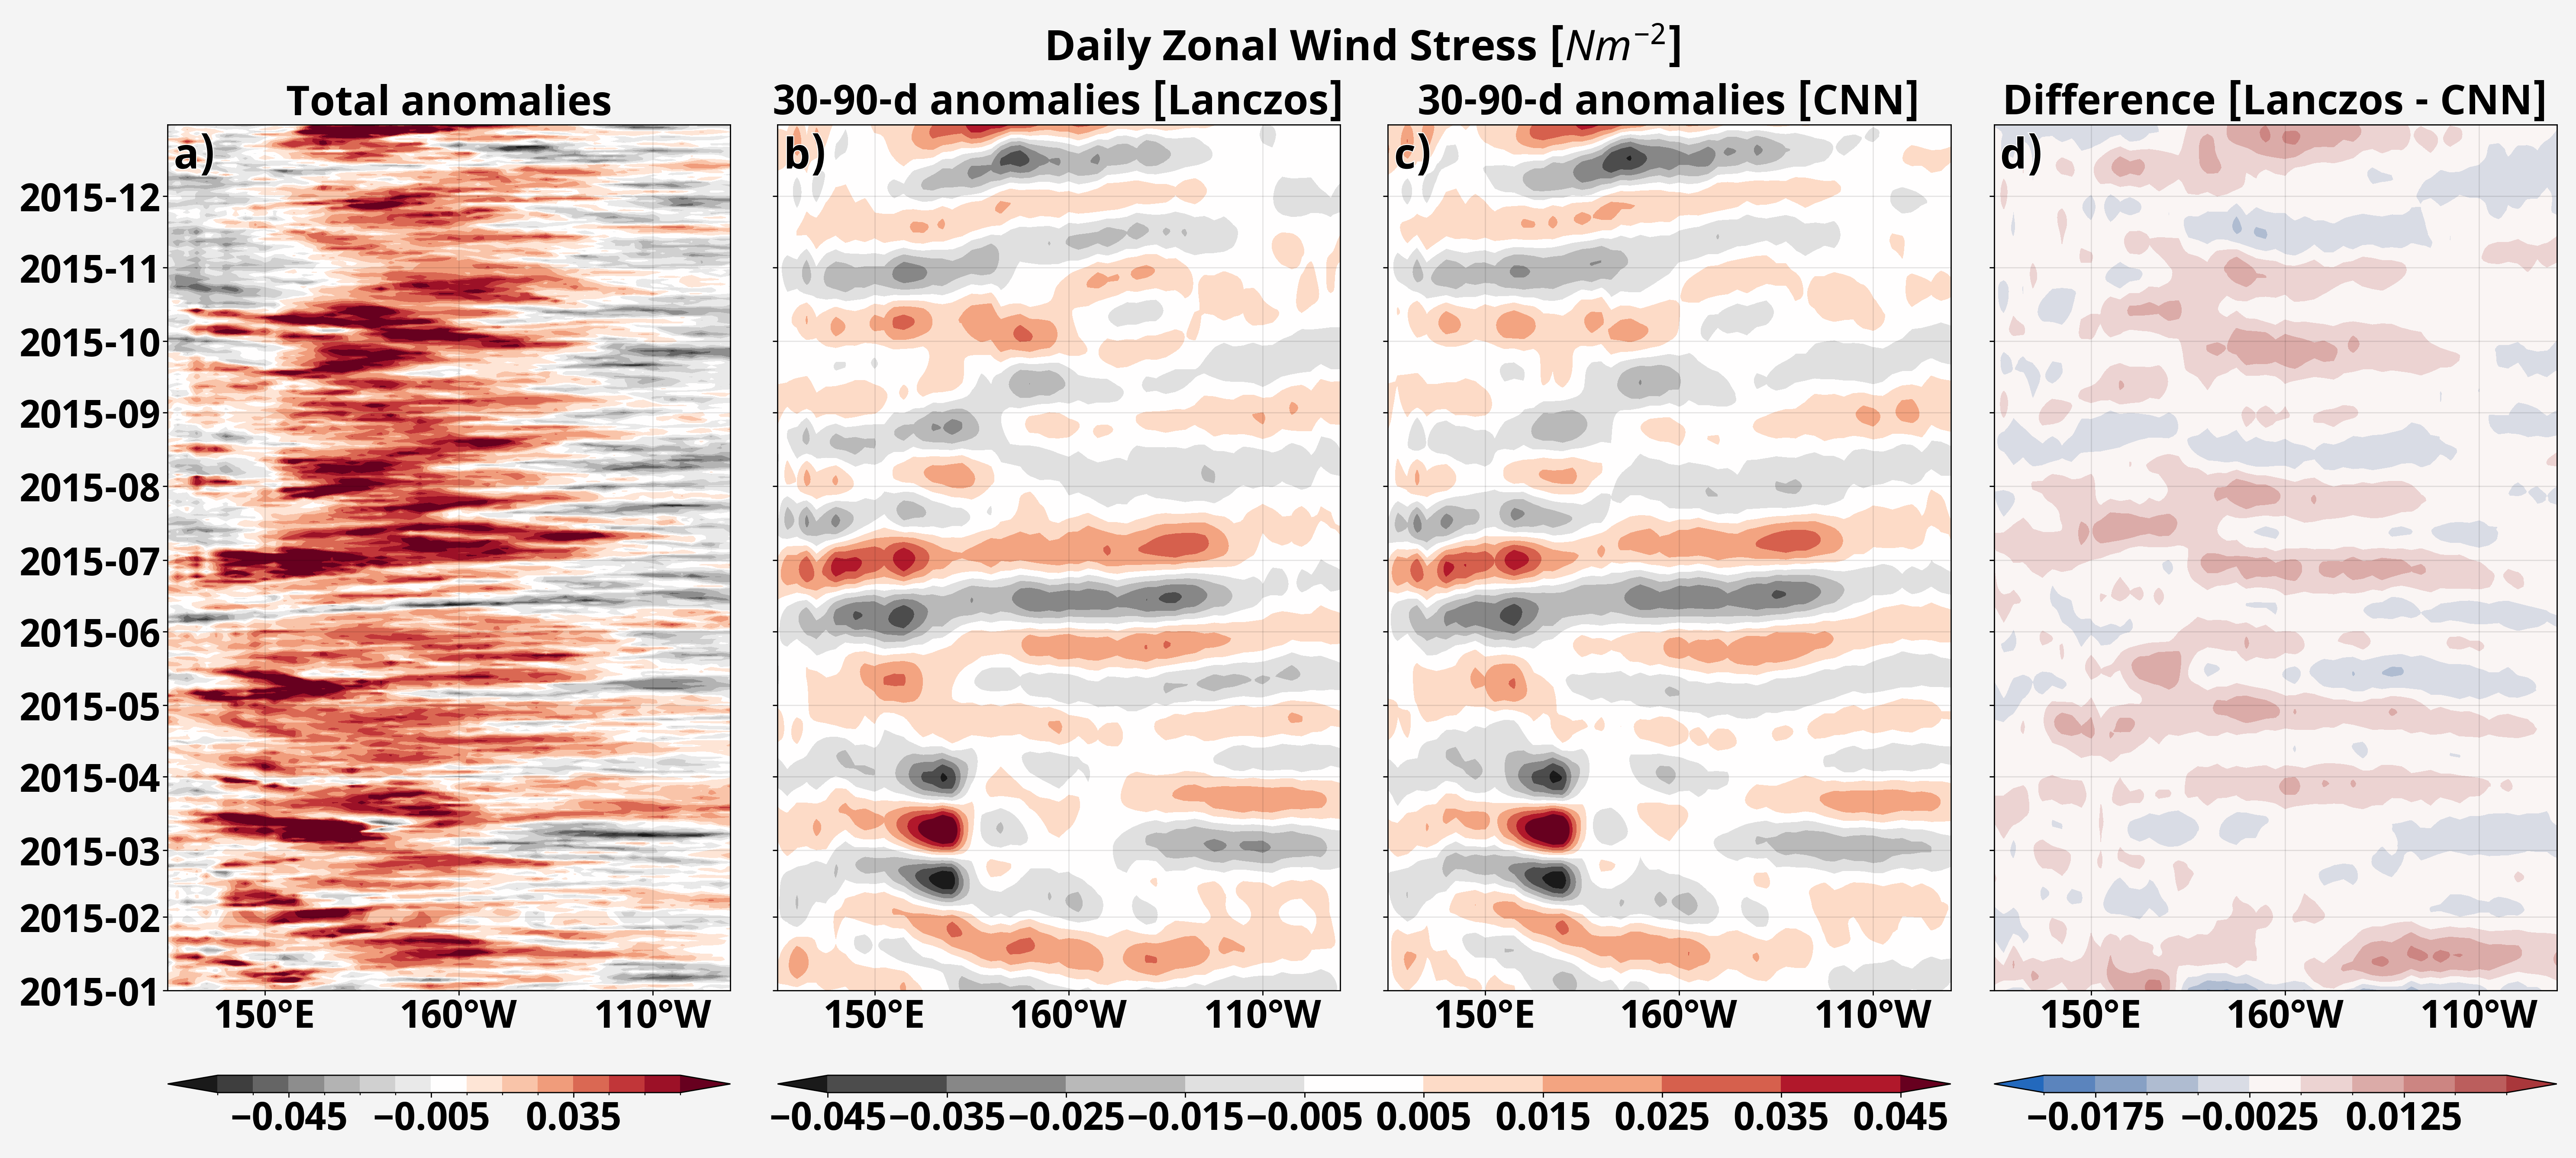

In [11]:
levels1 = [-0.065,-0.055,-0.045,-0.035,-0.025,-0.015,-0.005,0.005,0.015,0.025,0.035,0.045,0.055,0.065]
levels2 = [-0.045,-0.035,-0.025,-0.015,-0.005,0.005,0.015,0.025,0.035,0.045]
levels3 = [-0.0225,-0.0175,-0.0125,-0.0075,-0.0025,0.0025,0.0075,0.0125,0.0175,0.0225]


fig, axs = pplt.subplots(nrows=1,ncols=4,tight=True,refwidth=6.5,refheight=10)
axs.format(xlabel='',ylabel='',xformatter='deglon',xlocator=50,xtickminor=False,ytickminor=False,abc='a)',abcloc='ul')

vmin = tauxa_meanlat.sel(time=slice('2015','2015')).max().values
im1 = axs[0].contourf(tauxa_meanlat.sel(time=slice('2015','2015')),levels=levels1,extend='both',cmap='RdGy_r',colorbar=False)
im2 = axs[1].contourf(tauxi_meanlat_lan.sel(time=slice('2015','2015')),levels=levels2,extend='both',cmap='RdGy_r',colorbar=False)
axs[2].contourf(tauxi_meanlat_cnn.sel(time=slice('2015','2015')),levels=levels2,extend='both',cmap='RdGy_r',colorbar=False)
im3 = axs[3].contourf(tauxi_diff.sel(time=slice('2015','2015')),levels=levels3,extend='both',cmap='Vlag',colorbar=False)

axs[0].format(title='Total anomalies')
axs[1].format(title='30-90-d anomalies [Lanczos]')
axs[2].format(title='30-90-d anomalies [CNN]')
axs[3].format(title='Difference [Lanczos - CNN]')

fig.colorbar(im1,location='bottom',shrink= 1, width= 0.2,label='',col=1)
fig.colorbar(im2,location='bottom',shrink= 1, width= 0.2,label='',col=(2,3))
fig.colorbar(im3,location='bottom',shrink= 1, width= 0.2,label='',col=4)
fig.suptitle(r'Daily Zonal Wind Stress [$Nm^{-2}$]');

fig.savefig('Fig3a.png',dpi=150)

### Figure 4

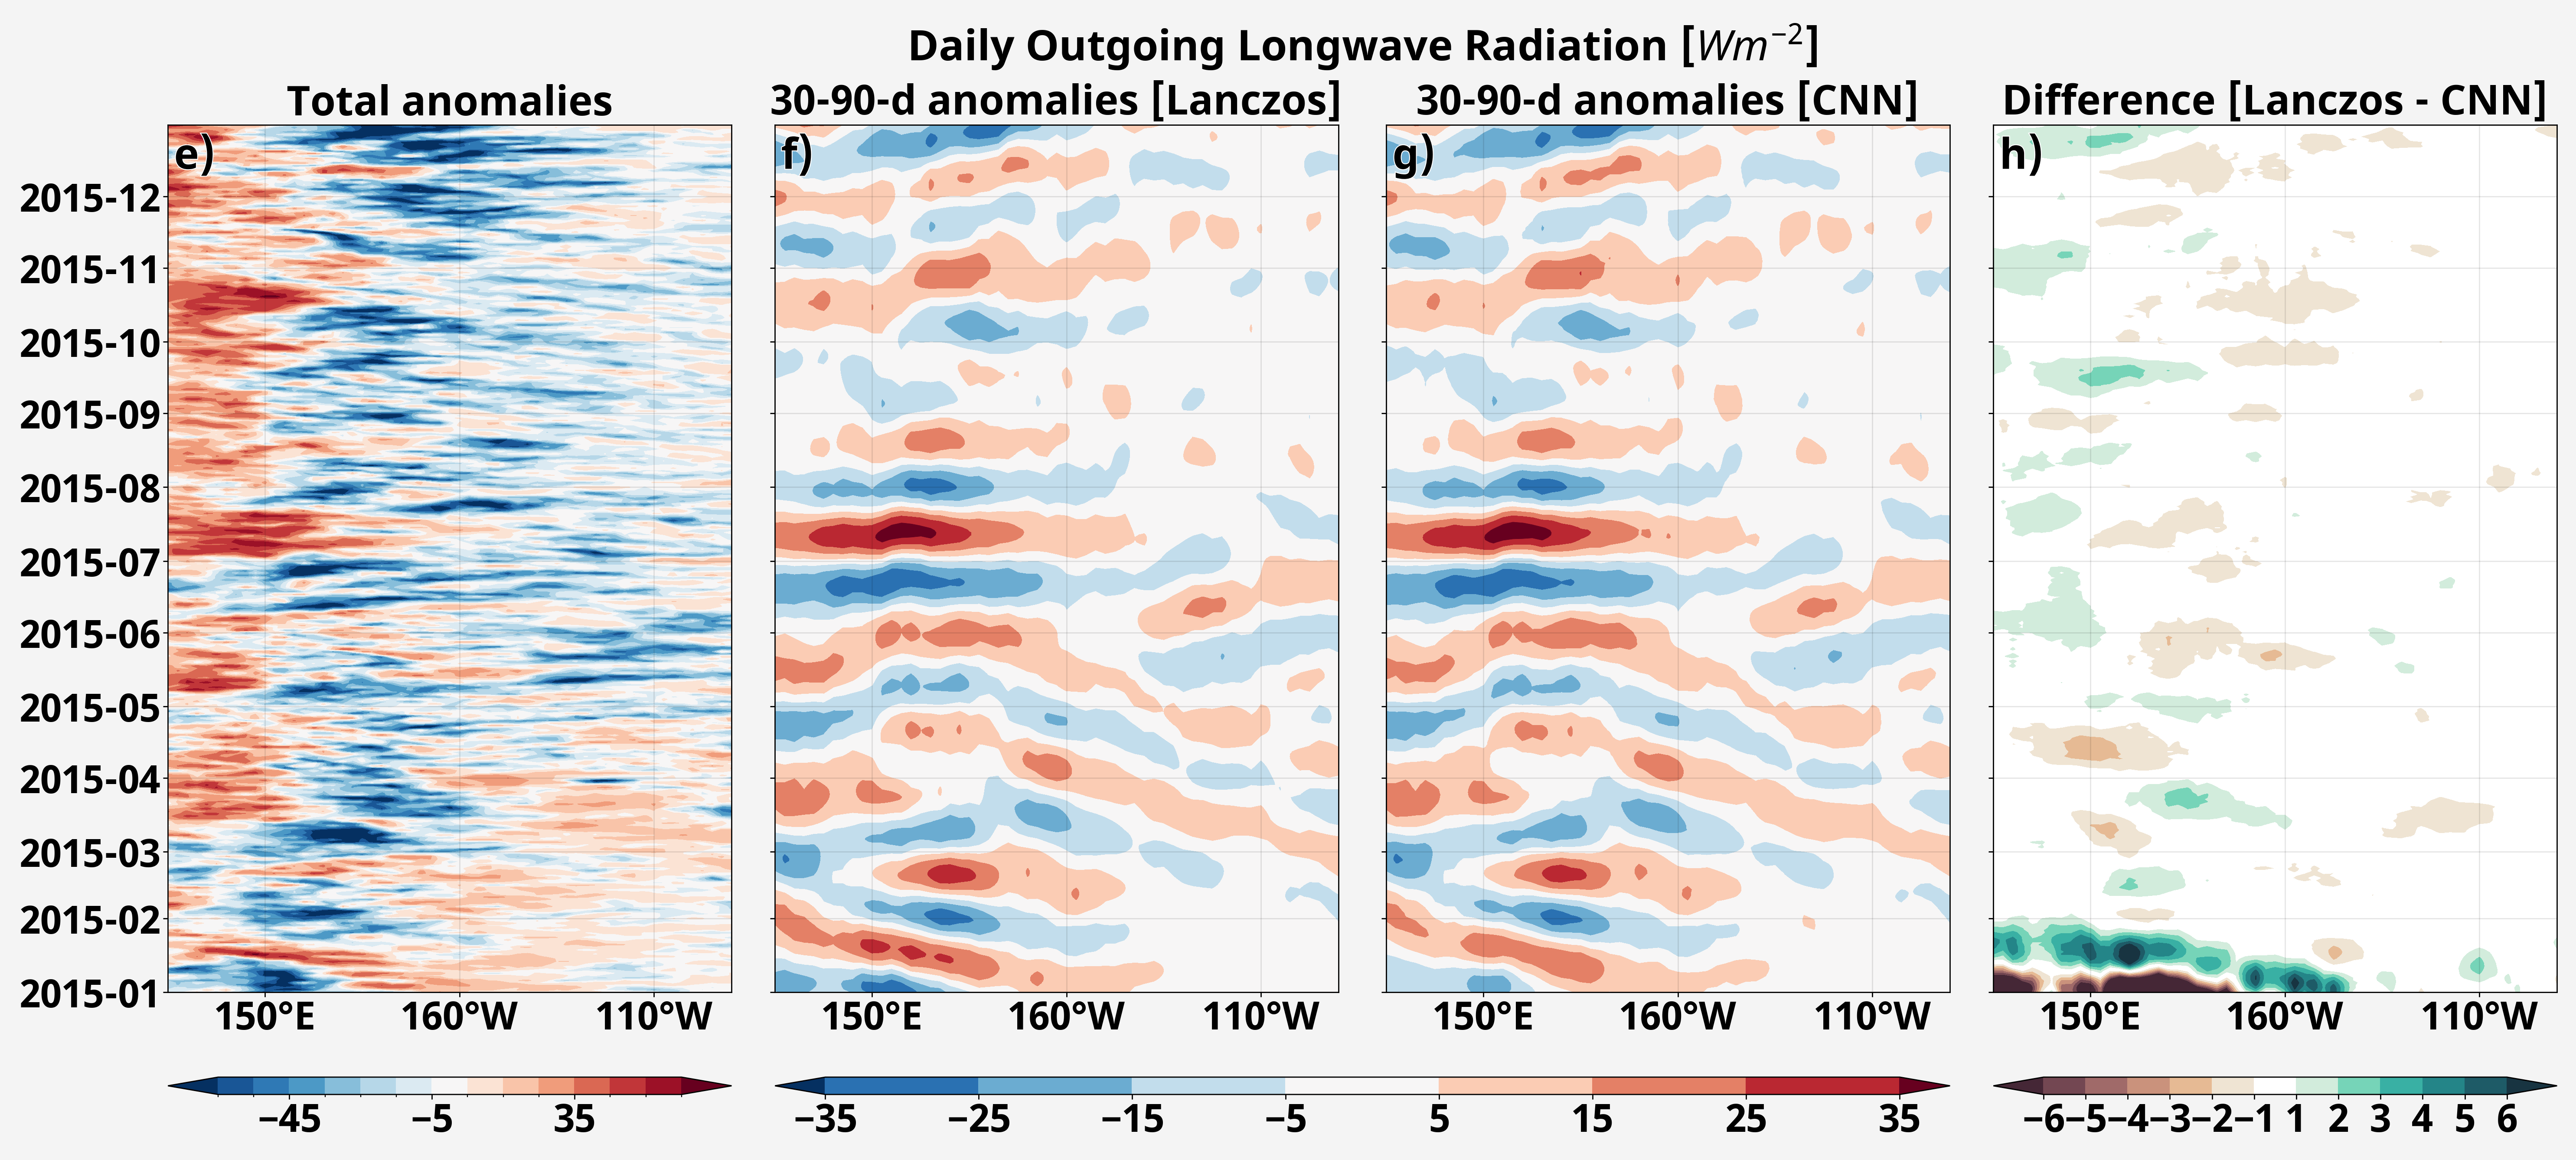

In [12]:
fig, axs = pplt.subplots(nrows=1,ncols=4,refwidth=6.5,refheight=10)

axs.format(xlabel='',ylabel='',xformatter='deglon',xlocator=50,xtickminor=False,ytickminor=False,abc=('e)','f)','g)','h)'),abcloc='ul')

levels1 = [-65,-55,-45,-35,-25,-15,-5,5,15,25,35,45,55,65]
#levels1 = np.arange(-60,75,15)
levels2 = [-35,-25,-15,-5,5,15,25,35]#np.arange(-36,40,6)
levels3 = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]#np.arange(-8,9,1)


im1 = axs[0].contourf(olra_meanlat.sel(time=slice('2015-01-1','2015-12-31')),levels=levels1,extend='both',cmap='RdBu_r',colorbar=False)
im2 = axs[1].contourf(olri_meanlat_lan.sel(time=slice('2015-01-1','2015-12-31')),levels=levels2,extend='both',cmap='RdBu_r',colorbar=False)
axs[2].contourf(olri_meanlat_cnn.sel(time=slice('2015-01-1','2015-12-31')),levels=levels2,extend='both',cmap='RdBu_r',colorbar=False)
im3 = axs[3].contourf(olri_diff.sel(time=slice('2015-01-1','2015-12-31')),levels=levels3,extend='both',cmap='DryWet',colorbar=False)

axs[0].format(title='Total anomalies')
axs[1].format(title='30-90-d anomalies [Lanczos]')
axs[2].format(title='30-90-d anomalies [CNN]')
axs[3].format(title='Difference [Lanczos - CNN]')


fig.colorbar(im1,location='bottom',shrink= 1, width= 0.2,label='',col=1)
fig.colorbar(im2,location='bottom',shrink= 1, width= 0.2,label='',col=(2,3))
fig.colorbar(im3,location='bottom',shrink= 1, width= 0.2,label='',col=4)

fig.suptitle(r'Daily Outgoing Longwave Radiation [$Wm^{-2}$]')

fig.savefig('Fig3b.png',dpi=150)

### Figure 4

The R-squared value will indicate the proportion of variance in the Lanczos band pass filtered anomalies that is explained by the predicted band pass filtered anomalies from the CNN model.

In [13]:
# Calcualting the RMSE and Index of Agreement for surface zonal wind stress
rmse = np.zeros(tauxi_meanlat_lan.shape[1])
ia = np.zeros(tauxi_meanlat_lan.shape[1])
r2_ws = np.zeros(tauxi_meanlat_lan.shape[1])

for i in range(tauxi_meanlat_lan.shape[1]):
    rmse[i] = np.sqrt(mean_squared_error(tauxi_meanlat_lan[:,i], tauxi_meanlat_cnn[:,i]))
    r2_ws[i] = r2_score(tauxi_meanlat_lan[:,i], tauxi_meanlat_cnn[:,i])
    ia[i] = index_agreement(tauxi_meanlat_cnn[:,i], tauxi_meanlat_lan[:,i])

In [14]:
# Calculating the power spectrum for surface zonal wind stress
f1,psd1 = sig.periodogram(tauxi_meanlat_lan.sel(time=slice('2015','2016'),lon=slice(125,160)).mean('lon'),scaling='density',detrend='linear',fs=1)
f2,psd2 = sig.periodogram(tauxi_meanlat_cnn.sel(time=slice('2015','2016'),lon=slice(125,160)).mean('lon'),scaling='density',detrend='linear',fs=1)

In [15]:
r, p = scipy.stats.pearsonr(tauxi_meanlat_lan.sel(time=slice('2015','2016'),lon=slice(125,160)).mean('lon'),tauxi_meanlat_cnn.sel(time=slice('2015','2016'),lon=slice(125,160)).mean('lon'))
r

0.9729109889502697

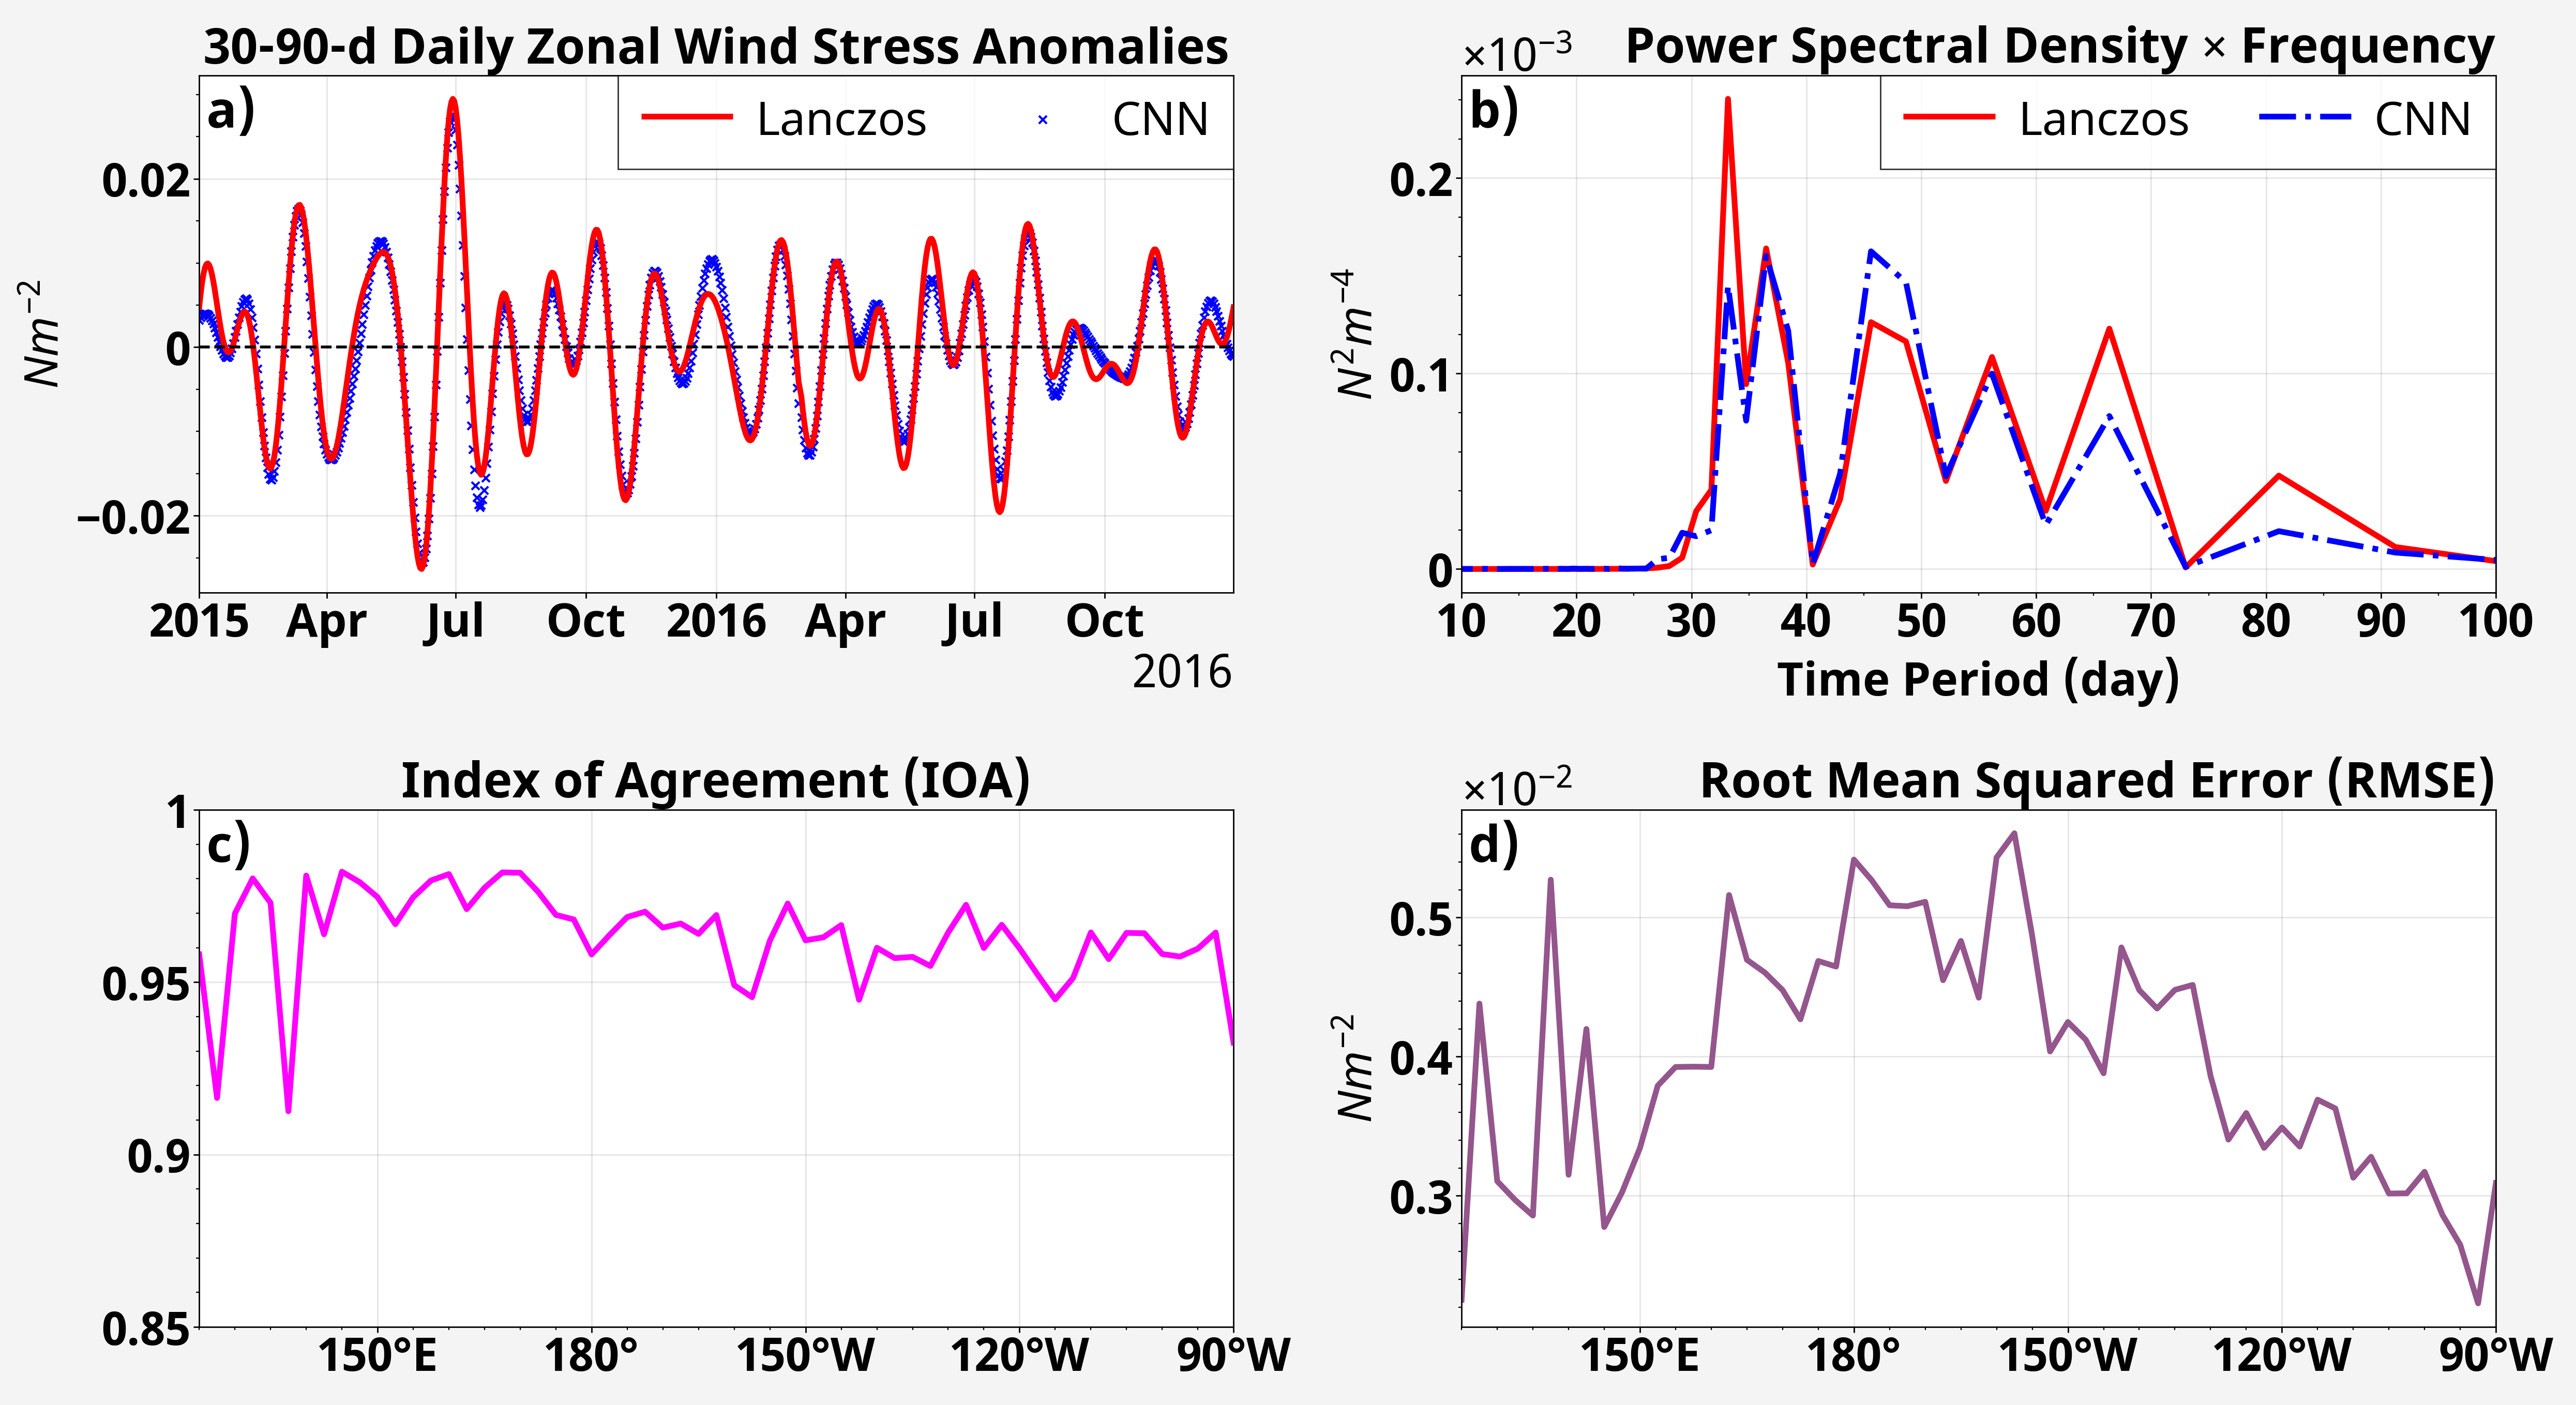

In [16]:
fig, axs = pplt.subplots(nrows=2,ncols=2,refwidth=10,refheight=5,share=0,span=False)
axs.format(abc='a)',abcloc='ul')

axs[0].scatter(tauxi_meanlat_cnn.sel(time=slice('2015','2016'),lon=slice(125,160)).mean('lon'),color='b',marker='x',markersize=30,label='CNN')
axs[0].plot(tauxi_meanlat_lan.sel(time=slice('2015','2016'),lon=slice(125,160)).mean('lon'),'r',lw=4,label='Lanczos')
axs[0].format(xformatter='concise',xrotation=0,xminorlocator=('month',4),title='30-90-d Daily Zonal Wind Stress Anomalies',ylabel=r'$Nm^{-2}$',xlabel='')#,xlocator=('month',3))
axs[0].axhline(y=0,color='black',ls='--',lw=2)
axs[0].legend(loc='best')

axs[1].plot(1/f1[7:],f1[7:]*psd1[7:],color='r',lw=4,label='Lanczos')
axs[1].plot(1/f2[7:],f2[7:]*psd2[7:],color='b',lw=4,ls='-.',label='CNN')
axs[1].legend(loc='best')
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
axs[1].format(xlim=(10,100),xlocator=10,xminorlocator=5,rtitle=r'Power Spectral Density $\times$ Frequency',ylabel=r'$N^2m^{-4}$',xlabel='Time Period (day)')

axs[2].plot(tauxi_meanlat_lan.lon.data,ia,lw=4,color='magenta')
axs[2].format(ylim=(0.85,1),xlocator=30,xminorlocator=5,title='Index of Agreement (IOA)',ylabel='',xlabel='',xformatter='deglon')

axs[3].plot(tauxi_meanlat_lan.lon.data,rmse,lw=4,color='purple')
axs[3].ticklabel_format(axis='y', style='sci', scilimits=(-2,-2))
axs[3].format(xlocator=30,xminorlocator=5,rtitle='Root Mean Squared Error (RMSE)',ylabel=r'$Nm^{-2}$',xlabel='',xformatter='deglon')

fig.savefig('Fig4.png',dpi=150)

### Figure 5

In [17]:
# Calcualting the RMSE and Index of Agreement for OLR

rmse = np.zeros(olri_meanlat_lan.shape[1])
ia = np.zeros(olri_meanlat_lan.shape[1])
r2_olr = np.zeros(olri_meanlat_lan.shape[1])

for i in range(olri_meanlat_lan.shape[1]):
    rmse[i] = np.sqrt(mean_squared_error(olri_meanlat_lan[:,i], olri_meanlat_cnn[:,i]))
    r2_olr[i] = r2_score(olri_meanlat_lan[:,i], olri_meanlat_cnn[:,i])
    ia[i] = index_agreement(olri_meanlat_cnn[:,i], olri_meanlat_lan[:,i])

In [18]:
# Calculating the power spectrum for surface zonal wind stress

f1,psd1 = sig.periodogram(olri_meanlat_lan.sel(time=slice('2015','2016'),lon=slice(160,190)).mean('lon'),scaling='density',detrend='linear',fs=1)
f2,psd2 = sig.periodogram(olri_meanlat_cnn.sel(time=slice('2015','2016'),lon=slice(160,190)).mean('lon'),scaling='density',detrend='linear',fs=1)

In [19]:
r, p = scipy.stats.pearsonr(olri_meanlat_lan.sel(time=slice('2015','2016'),lon=slice(160,190)).mean('lon'),olri_meanlat_cnn.sel(time=slice('2015','2016'),lon=slice(160,190)).mean('lon'))
r

0.9904724662876058

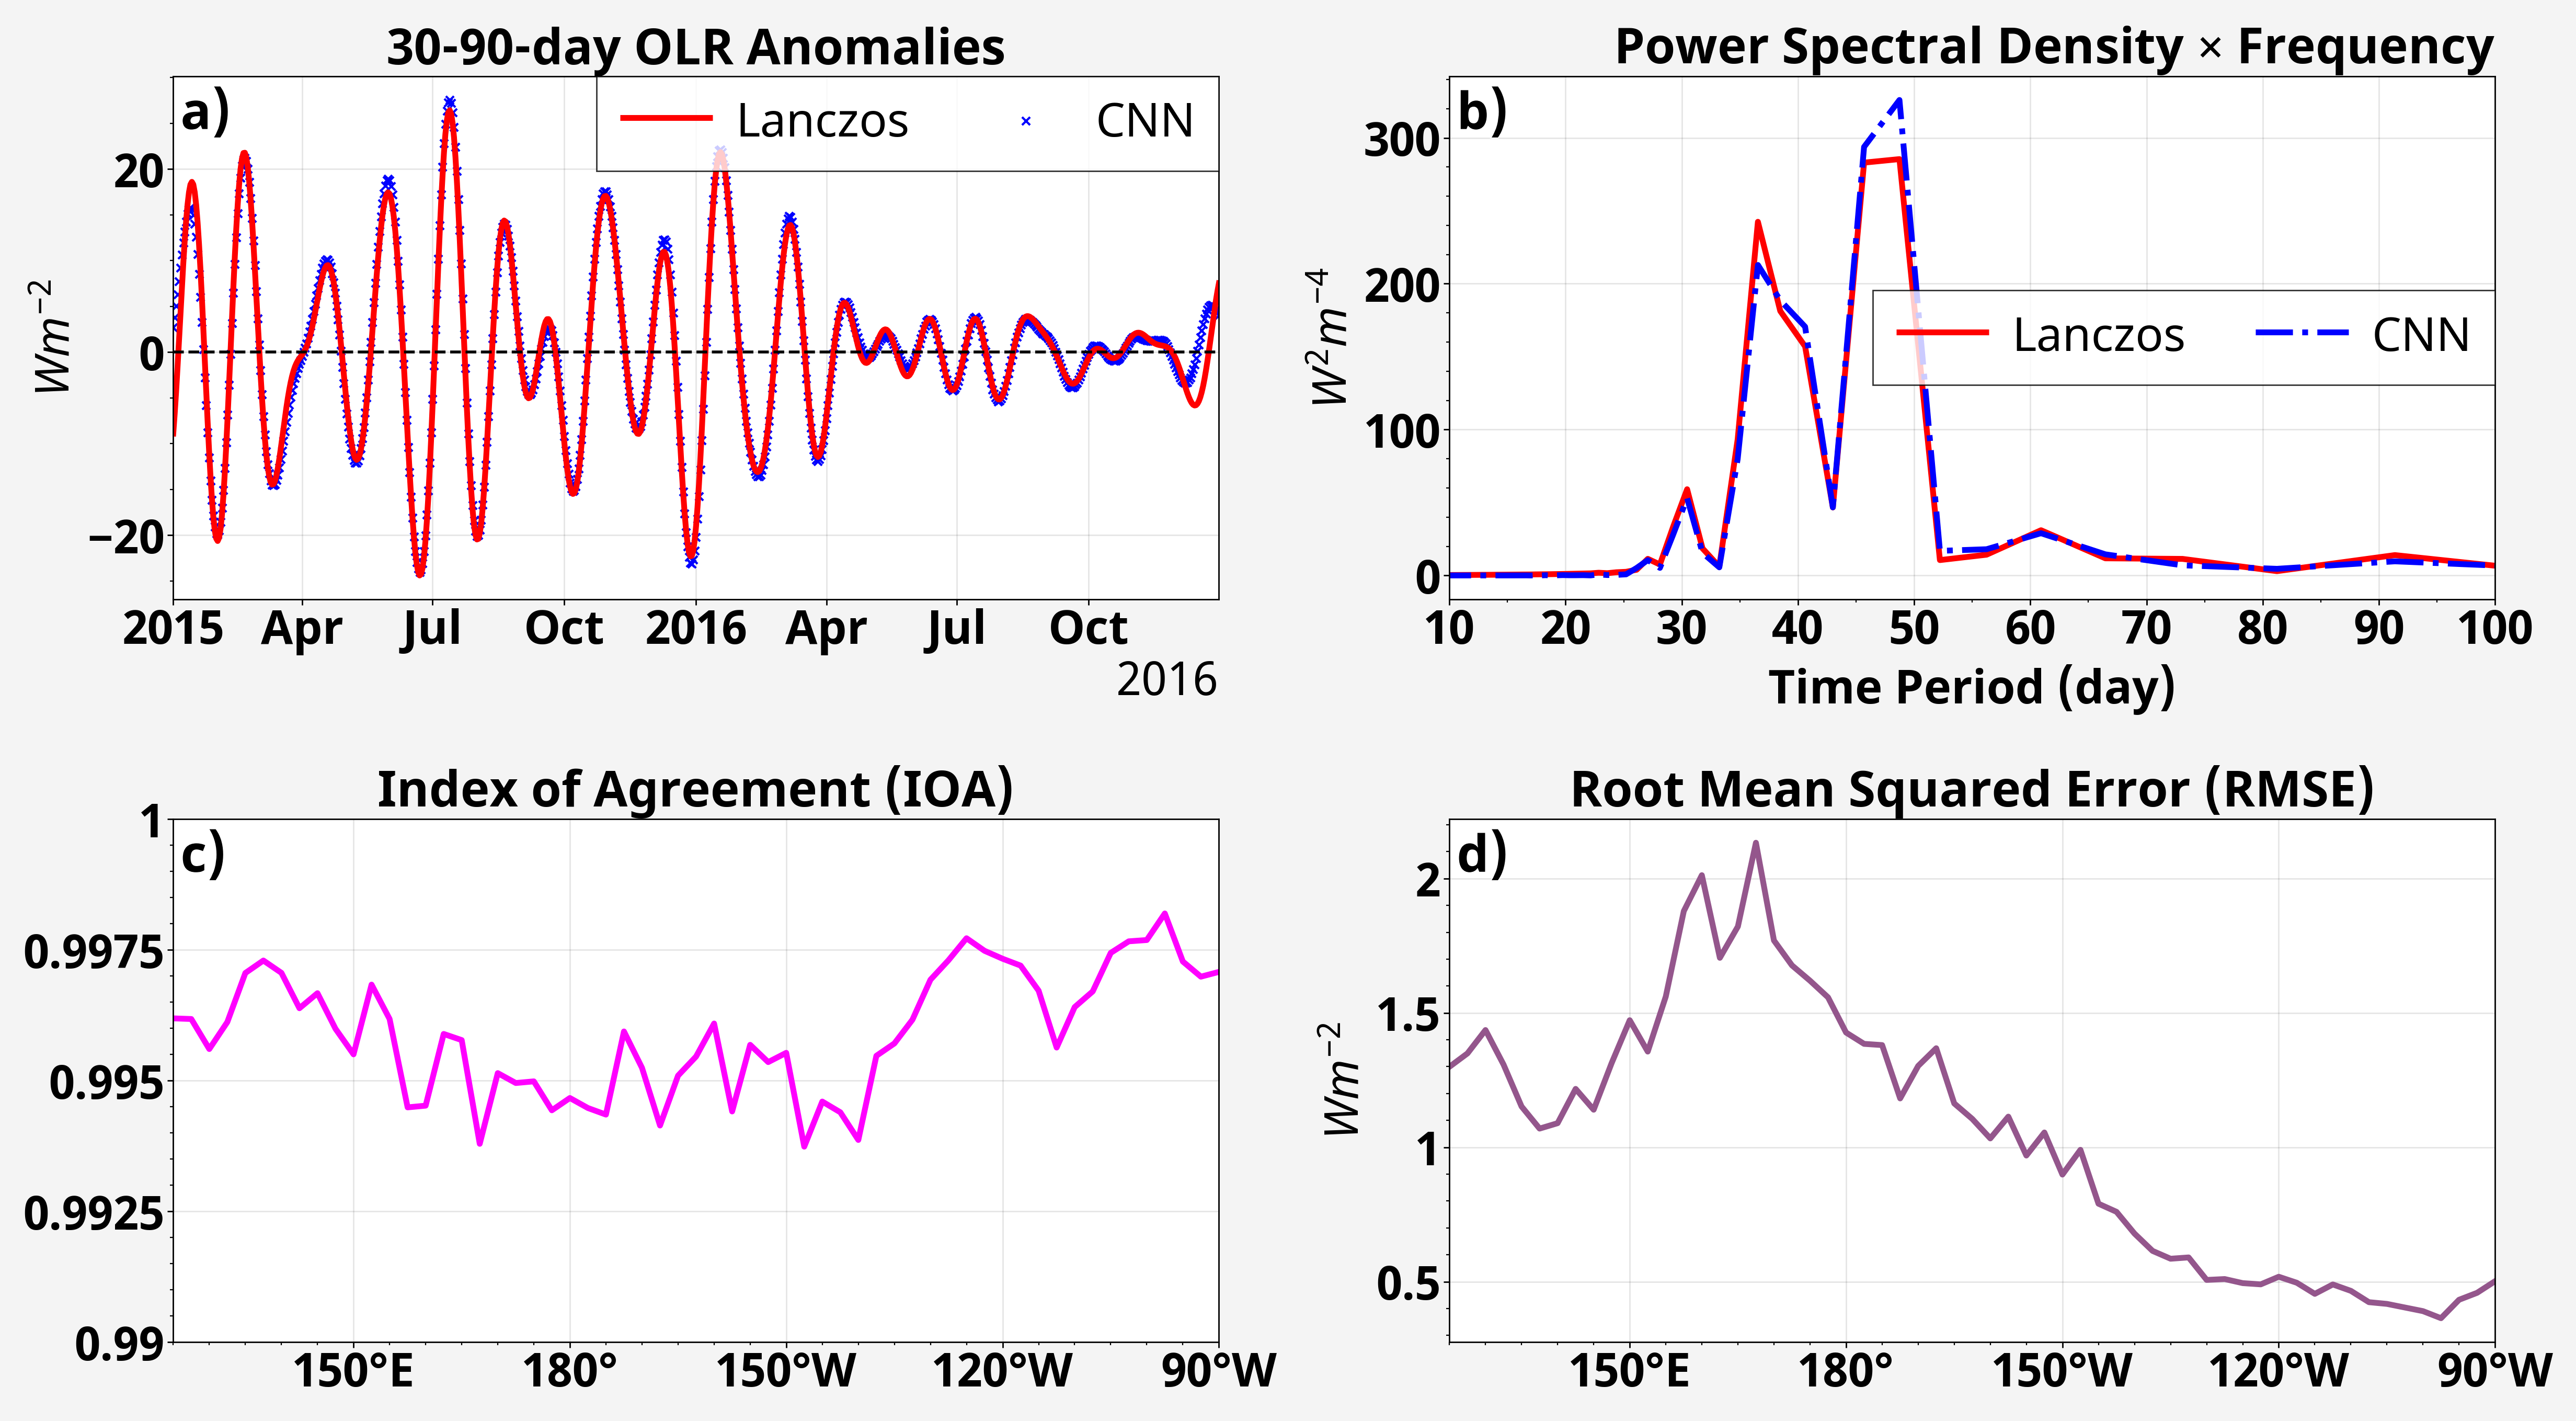

In [20]:
fig, axs = pplt.subplots(nrows=2,ncols=2,refwidth=10,refheight=5,share=0,span=False)
axs.format(abc='a)',abcloc='ul')

axs[0].scatter(olri_meanlat_cnn.sel(time=slice('2015','2016'),lon=slice(160,190)).mean('lon'),color='b',marker='x',markersize=30,label='CNN')
axs[0].plot(olri_meanlat_lan.sel(time=slice('2015','2016'),lon=slice(160,190)).mean('lon'),'r',lw=4,label='Lanczos')
axs[0].format(xformatter='concise',xrotation=0,xminorlocator=('month',4),title='30-90-day OLR Anomalies',ylabel=r'$Wm^{-2}$',xlabel='')#,xlocator=('month',3))
axs[0].axhline(y=0,color='black',ls='--',lw=2)
axs[0].legend(loc='best')

axs[1].plot(1/f1[7:],f1[7:]*psd1[7:],color='r',lw=4,label='Lanczos')
axs[1].plot(1/f2[7:],f2[7:]*psd2[7:],color='b',lw=4,ls='-.',label='CNN')
axs[1].legend(loc='best')
axs[1].format(xlim=(10,100),xlocator=10,xminorlocator=5,rtitle=r'Power Spectral Density $\times$ Frequency',ylabel=r'$W^2m^{-4}$',xlabel='Time Period (day)')

axs[2].plot(olri_meanlat_lan.lon.data,ia,lw=4,color='magenta')
axs[2].format(ylim=(0.99,1),xlocator=30,xminorlocator=5,title='Index of Agreement (IOA)',ylabel='',xlabel='',xformatter='deglon')

axs[3].plot(olri_meanlat_lan.lon.data,rmse,lw=4,color='purple')
axs[3].format(xlocator=30,xminorlocator=5,title='Root Mean Squared Error (RMSE)',ylabel=r'$Wm^{-2}$',xlabel='',xformatter='deglon')

fig.savefig('Fig5.png',dpi=150)

### Figure 6

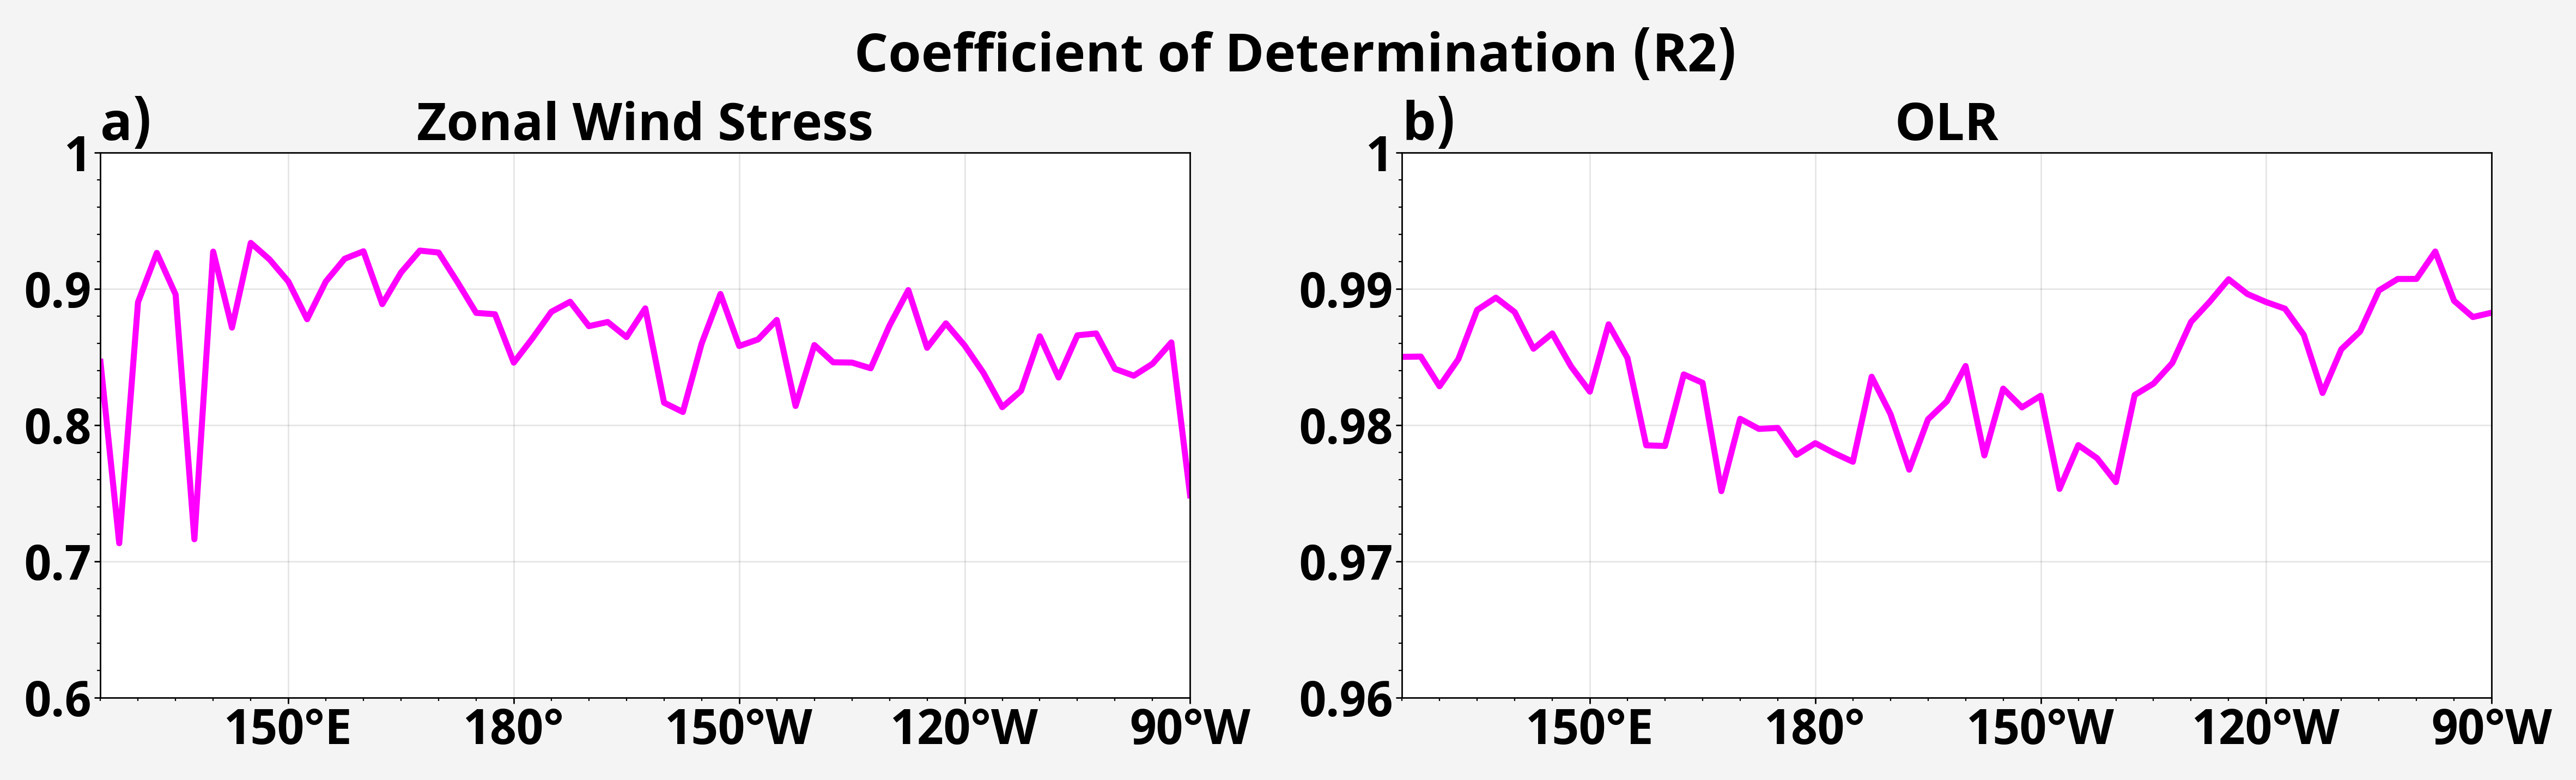

In [21]:
fig, axs = pplt.subplots(nrows=1,ncols=2,refwidth=10,refheight=5,share=0,span=False)
axs.format(abc='a)',abcloc='l')

axs[0].plot(tauxi_meanlat_lan.lon.data,r2_ws,lw=4,color='magenta')
axs[0].format(ylim=(0.6,1),xlocator=30,xminorlocator=5,title='Zonal Wind Stress',ylabel='',xlabel='',xformatter='deglon')

axs[1].plot(olri_meanlat_lan.lon.data,r2_olr,lw=4,color='magenta')
axs[1].format(ylim=(0.96,1),xlocator=30,xminorlocator=5,title='OLR',ylabel='',xlabel='',xformatter='deglon')

fig.suptitle('Coefficient of Determination (R2)');

fig.savefig('Fig6.png',dpi=150)